In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.primitives import BackendEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from qiskit_nature.second_q.mappers import ParityMapper

seed = 100
driver = PySCFDriver(
    atom=f"H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
es_problem = driver.run()
mapper = ParityMapper(num_particles=es_problem.num_particles)

def create_ansatz(es_problem):
    return UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

def create_vqe_solver(estimator, ansatz):
    vqe_solver = VQE(estimator, ansatz, SPSA())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    return vqe_solver

class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1, t2):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.time_cx = 150
        self.time_swap = 40
        self.single_gate_times = {
            "h": 40,
            "x": 40,
            "y": 40,
            "z": 40,
            "s": 40,
            "rx": 40,
            "rz": 40,
            "sdg": 40,
        }

        self.add_errors()

    def add_errors(self):
        for gate, time in self.single_gate_times.items():
            self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, time), gate)
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_cx)
            .expand(thermal_relaxation_error(self.t1, self.t2, self.time_cx)), "cx")
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_swap)
            .expand(thermal_relaxation_error(self.t1, self.t2, self.time_swap)), "swap")


class EnergyCalculator:
    def __init__(self, acc):
        self.estimator = AerEstimator(
            backend_options={
                "method": "density_matrix",
                "coupling_map": [(0, 1), (1, 2)],
                "noise_model": ThermalNoiseModel(acc * 1e3, acc * 0.5e3),
            },
            run_options={"seed": seed, "shots": 1024},
            transpile_options={"seed_transpiler": seed},
        )
        self.calc = GroundStateEigensolver(mapper, create_vqe_solver(self.estimator, ansatz))
        self.vqe_energies = []

    def calculate(self):
        self.vqe_energies = []
        for distance in distances:
            driver = PySCFDriver(
                atom=f"H 0 0 0; H 0 0 {distance}",
                basis="sto3g",
                charge=0,
                spin=0,
                unit=DistanceUnit.ANGSTROM,
            )
            es_problem = driver.run()
            res = self.calc.solve(es_problem)
            self.vqe_energies.append(res.eigenvalues[0] + res._nuclear_repulsion_energy)

    def minimum(self):
        kernel_size = 5
        kernel = np.ones(kernel_size) / kernel_size
        smoothed_energies = np.convolve(self.vqe_energies, kernel, mode='valid')
        adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[kernel_size // 2:-kernel_size // 2]
        return smoothed_energies.min(), adjusted_distances[smoothed_energies.argmin()]

ansatz = create_ansatz(es_problem)

for i in range(4, 5):
    distances = np.arange(0.70, 1.15, 0.05)
    accuracies = np.arange(1, 101, 1)
    
    results = []
    for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
        calculator = EnergyCalculator(accuracy)
        calculator.calculate()
        results.append(calculator.minimum())
    
    energies = []
    min_dist = []
    for result in results:
        energies.append(result[0].item())
        min_dist.append(result[1].item())
        
    energies = np.array(energies)
    min_dist = np.array(min_dist)
    
    df = pd.read_csv("energy_acc.csv")
    df[f"energy{i}"] = energies
    df.to_csv("energy_acc.csv", index=False)

Evaluating simulation:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2812/1538040742.py:127: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  calculator = EnergyCalculator(accuracy)
Evaluating simulation:   1%|          | 1/100 [00:05<09:24,  5.70s/it]/tmp/ipykernel_2812/1538040742.py:127: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  calculator = EnergyCalculator(accuracy)
Evaluating simulation:   2%|▏         | 2/100 [00:11<09:18,  5.69s/it]/tmp/ipykernel_2812/1538040742.py:127: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator fro

In [57]:
import pandas as pd
accuracies = np.arange(1, 101, 1)
df = pd.read_csv("energy_acc.csv")
energy_axis = [f"energy{i}" for i in range(1, 7)]
df['mean_energy'] = df[energy_axis].mean(axis=1)
energies = np.array(df["mean_energy"])
df.head()

,dist,energy1,energy2,energy3,energy4,energy5,energy6,mean_energy
0,1.0,-0.618578,-0.615402,-0.635923,-0.630130,-0.639726,-0.608404,-0.624694
1,1.0,-0.751428,-0.737390,-0.740217,-0.738122,-0.743315,-0.743617,-0.742348
2,1.0,-0.809558,-0.825435,-0.832767,-0.827050,-0.833476,-0.820403,-0.824782
3,1.0,-0.870550,-0.871856,-0.871662,-0.876085,-0.880268,-0.868830,-0.873209
4,1.0,-0.905712,-0.906047,-0.917419,-0.911825,-0.916013,-0.905603,-0.910437


In [58]:
from scipy.optimize import curve_fit

def func(x, a, b, c, p):
  return (a * np.exp(-b * x)) / np.sqrt(x + c) + p

params, covariance = curve_fit(func, accuracies, energies, (0.5, 0.05, 0.5, 0), maxfev=10000)
a, b, c, p = params
y_fit = func(np.arange(1, 101, 1), *params)
print(*params)

0.6206035639512464 0.047668648647810175 0.42639688225422434 -1.1160955097904481


In [59]:
from sklearn.metrics import r2_score
r2_score(energies, y_fit)

0.9992639858166523

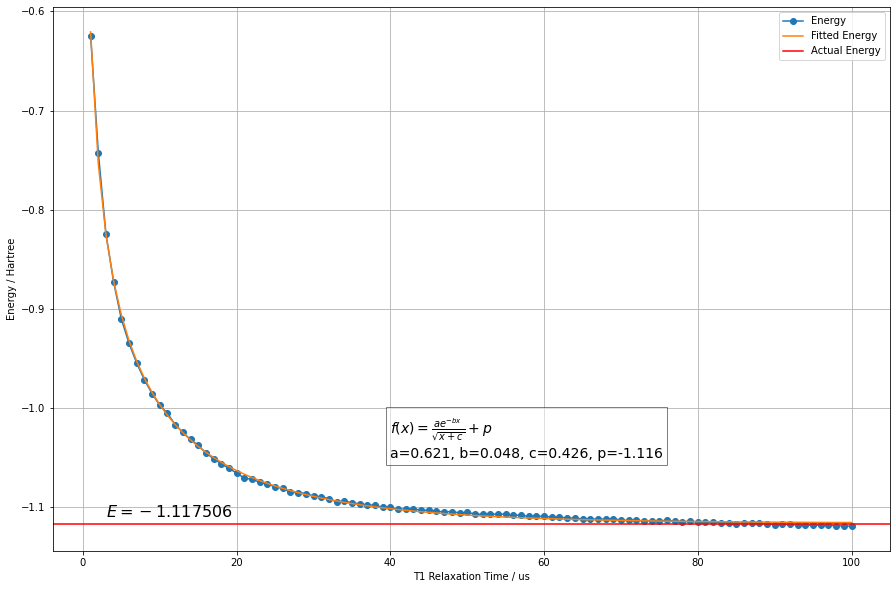

In [66]:
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, energies, 'o-', label="Energy")
plt.plot(accuracies, y_fit, label="Fitted Energy")
equation_text = r'$f(x) = \frac{{ae^{{-bx}}}}{{\sqrt{{x + c}}}} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, p={p:.3f}'
plt.text(40, -1.05, equation_text + '\n' + params_text, fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
plt.text(3, -1.11, r'$E = -1.117506$', fontsize=16)
plt.axhline(y=-1.117506, color='r', label="Actual Energy")
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()

In [62]:
actual = -1.117506

/tmp/ipykernel_2812/1024617922.py:13: RuntimeWarning: invalid value encountered in sqrt
  return (a * np.exp(-b * x)) / np.sqrt(x + c) + p


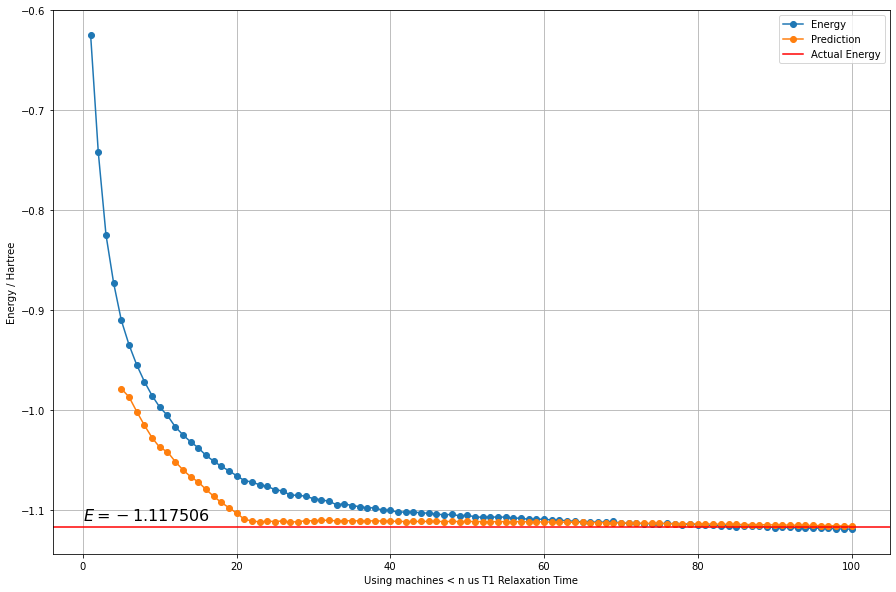

In [69]:
guesses = []
for limit in range(5, 101):
  params, covariance = curve_fit(func, accuracies[:limit], energies[:limit], (0.6, 0.05, 0.5, 0), maxfev=10000)
  a, b, c, p = params
  guesses.append(p)

guesses = np.array(guesses)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, energies, 'o-', label="Energy")
plt.text(0, -1.11, r'$E = -1.117506$', fontsize=16)
plt.plot(np.arange(5, 101, 1), guesses, 'o-', label="Prediction")
plt.axhline(y=-1.117506, color='r', label="Actual Energy")
plt.xlabel('Using machines < n us T1 Relaxation Time')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()